#### Import modules

In [1]:
import pandas as pd
import datetime
import os
import zipfile
import glob
import requests
import shutil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import re

#### Define functions

In [2]:
def download_datasets(urls, start_year, end_year):
    # for year in range(start_year, end_year + 1):
    for download_url in urls:
        # download_url = url.replace('2023', str(year))
        print(f'downloading {download_url}')
        response = requests.get(download_url)
        if response.status_code == 200:
            file_name = download_url.split('/')[-1]
            with open(file_name, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded {file_name}")
        else:
            print(f"Failed to download {download_url}")
                
def load_data_to_df(projects):
    current_year = datetime.datetime.now().year
    all_data = []
    for project in projects:
        for year in range(2023, current_year + 1):
            archive_name = f"{year}_{project}.zip"
            # Assuming the archive is downloaded in the current working directory
            with zipfile.ZipFile(archive_name, 'r') as z:
                z.extractall("temp_data")
                for filename in glob.glob(f"temp_data/data/transcriptions/{project}/*.txt"):
                    with open(filename, 'r', encoding='utf-8') as file:
                        text = file.read()
                        # Extract date and time from the filename
                        basename = os.path.basename(filename)
                        datetime_str = basename.split('.')[0]  # Remove the file extension

                        # Split into date and time components
                        date_part, time_part = datetime_str.split('_')
                        # Format time part correctly (replace '-' with ':')
                        time_part_formatted = time_part.replace('-', ':')

                        # Combine date and time with a space
                        datetime_str_formatted = f"{date_part} {time_part_formatted}"

                        all_data.append({"project": project, "date": datetime_str_formatted, "text": text})

                # Cleanup extracted files
                shutil.rmtree(f"temp_data/data/transcriptions/{project}")
            # Cleanup the remaining temporary directory
            shutil.rmtree("temp_data")
    
    return pd.DataFrame(all_data)

def search_text_in_dataset(df, projects=None, search_text=None, date_start=None, date_end=None):
    # Filter by projects if specified
    if projects:
        df = df[df['project'].isin(projects)]

    # Assuming the 'date' field includes time information and is in a standard format like 'yyyy-mm-dd hh:mm:ss'
    df['date'] = pd.to_datetime(df['date'])

    # Filter by date range if specified
    if date_start:
        df = df[df['date'] >= pd.to_datetime(date_start, format='%Y-%m-%d %H:%M:%S')]
    if date_end:
        df = df[df['date'] <= pd.to_datetime(date_end, format='%Y-%m-%d %H:%M:%S')]

    # Search for text and count occurrences (case-insensitive)
    if search_text:
        search_text_lower = search_text.lower()  # Convert search text to lowercase
        df['count_of_references'] = df['text'].apply(lambda x: x.lower().count(search_text_lower))
    else:
        df['count_of_references'] = 0

    # Returning the project, date, count of references, and text
    return df[['project', 'date', 'count_of_references', 'text']]

    
def plot_references_timeline(df):
    # Ensure 'date' is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Define a custom list of distinct colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # Assign a unique color to each project
    unique_projects = df['project'].unique()
    if len(unique_projects) > len(colors):
        raise ValueError("Not enough colors for the number of projects. Add more colors to the list.")

    color_map = {project: colors[i] for i, project in enumerate(unique_projects)}

    # Prepare the plot
    plt.figure(figsize=(10, 6))

    for project in unique_projects:
        project_df = df[df['project'] == project]
        plt.scatter(project_df['date'], project_df['count_of_references'], 
                    alpha=0.7, color=color_map[project], label=project)

    # Formatting the date on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels

    plt.title('Timeline of References')
    plt.xlabel('Date and Time')
    plt.ylabel('Count of References')
    plt.legend()

    plt.show()
    
def extract_sentences_with_reference(df, reference):
    result = []
    for index, row in df.iterrows():
        # Split text into sentences
        sentences = re.split(r'[.?!]', row['text'])

        # Check each sentence for the reference
        for sentence in sentences:
            if reference.lower() in sentence.lower():
                result.append(f"{row['date']} {row['project']} {sentence.strip()}.")
    return result

#### Download dataset

In [3]:
current_year = datetime.datetime.now().year
projects = ['ORT', 'belarusone', 'oneplusone', 'russiaone']
urls = []
for year in range(2023, current_year + 1):
    for project in projects:
        urls.append(f"https://storage.googleapis.com/rtlm/{year}_{project}.zip")
print(urls)
download_datasets(urls, 2023, current_year)

# Save to df
projects = [url.split('/')[-1].split('_')[1].split('.')[0] for url in urls]
# Create the DataFrame
df = load_data_to_df(projects)
df.head(2)

['https://storage.googleapis.com/rtlm/2023_ORT.zip', 'https://storage.googleapis.com/rtlm/2023_belarusone.zip', 'https://storage.googleapis.com/rtlm/2023_oneplusone.zip', 'https://storage.googleapis.com/rtlm/2023_russiaone.zip']
downloading https://storage.googleapis.com/rtlm/2023_ORT.zip
Downloaded 2023_ORT.zip
downloading https://storage.googleapis.com/rtlm/2023_belarusone.zip
Downloaded 2023_belarusone.zip
downloading https://storage.googleapis.com/rtlm/2023_oneplusone.zip
Downloaded 2023_oneplusone.zip
downloading https://storage.googleapis.com/rtlm/2023_russiaone.zip
Downloaded 2023_russiaone.zip


,project,date,text
0,ORT,2023-11-08 20:24:32,Казаться от самостоятельной линии во внешних ...
1,ORT,2023-11-27 16:22:12,Подарок. Купи Infinix со связи и получи второ...


#### Search for phrase

ORT 9
belarusone 4
oneplusone 13
russiaone 4


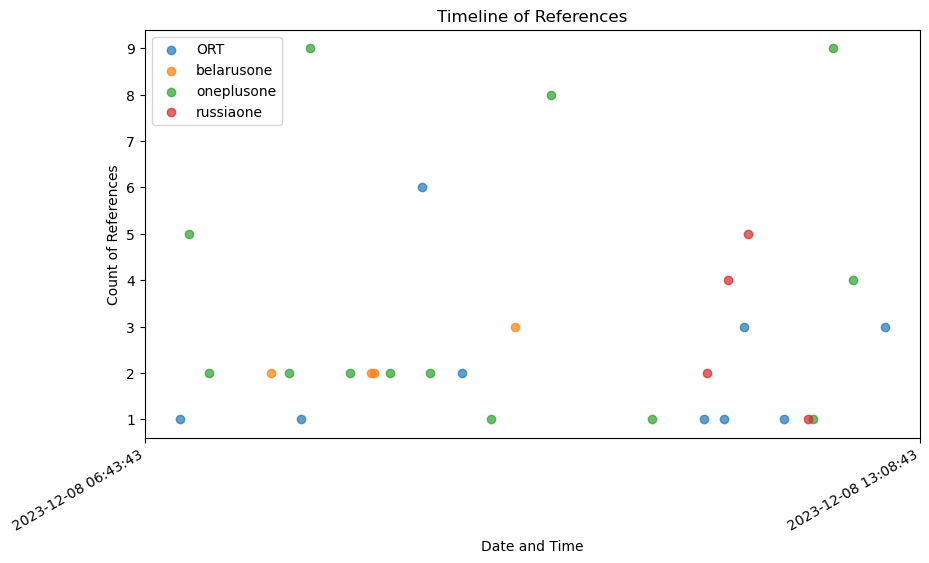

,project,date,count_of_references,text
116,ORT,2023-12-08 11:31:20,1,"Они будут находить эти прокси-силы, вот такие..."
579,ORT,2023-12-08 11:41:20,3,Если мы переправимся через этот водораздельны...


In [4]:
search_text='дрон'
date_start='2023-12-08 07:00:00'
date_end='2023-12-08 13:00:00'
projects=['ORT', 'russiaone', 'belarusone', 'oneplusone']

result_df = search_text_in_dataset(
    df,
    projects,
    search_text, 
    date_start, 
    date_end
)
result_df = result_df[result_df.count_of_references>0]
# Group by project and count the number of entries for each project
project_counts = result_df.groupby('project').size()
for pc in project_counts.items():
    print(pc[0], pc[1])
plot_references_timeline(result_df)
result_df.head(2)

#### Print all sentences, contains the search phrase

In [6]:
sorted_df = result_df.sort_values(by=['date', 'project'])
sentences = extract_sentences_with_reference(sorted_df, search_text)
for sentence in sentences:
    print(sentence, '\n')

2023-12-08 07:01:13 ORT На счету бойца с позывным «Стрелок» более 30 ликвидированных боевиков и десяток сбитых дронов. 

2023-12-08 07:05:32 oneplusone Та ще їхні дрони допомагають. 

2023-12-08 07:05:32 oneplusone Дронів стало безпосередньо більше. 

2023-12-08 07:05:32 oneplusone За день можна нарахувати до 50 дронів. 

2023-12-08 07:05:32 oneplusone На даний час завдяки волонтерам відновлюються дві автівки після того, як ворожі дрони влучили в них. 

2023-12-08 07:05:32 oneplusone Місцеві розповідають, що бачать ворожі дрони та гарно чують звуки стрілецьких боїв. 

2023-12-08 07:15:40 oneplusone Якщо говорити про спрямування цих коштів, то це і тисячі комплексів безпілотників, а також морські дрони, 200 реанімобілів високого класу, броньовані швидкі, сотні генераторів для лікарень та іншого обладнання. 

2023-12-08 07:15:40 oneplusone І я дякую вам, хлопці, за кожен збитий ворожий дрон. 

2023-12-08 07:46:27 belarusone Я выбираю Милдронат 250 миллиграмм. 

2023-12-08 07:46:27 belaru

#### Next, you can search for insights, summarize and answer your questions using one of modern LLM